# Fórmulas de Derivación e Integración Numérica

Autor: Pedro González Rodelas

Fecha de la primera versión: 08/09/2017

Sucesivas revisiones: 22/09/2017, 12,19/09/2018, 29/03 y 20/04/2020

Fecha de la última revisión: 06/04/2020

Estructura del notebook y algunos ejemplos tomados o adaptados de los libros:

- "Numerical Python: A Practical Techniques Approach for Industry" de Robert Johansson. Edit. Apress (2015) con ISBN-13 (electronic): 978-1-4842-0553-2
- "Numerical Methods in Engineering with Python 3" de Jaan Kiusalaas. Edit Cambridge Univ. Press (2013) con ISBN: 978-1-107-03385-6
- "Análisis Numérico con Mathematica" de V. Ramírez, D. Barrera, M. Pasadas y P. González. Edit. Ariel Ciencia (2001) con ISBN: 84-344-8036-0. Dep. Legal: B.31.425-2001

En esta práctica nos ocuparemos de los métodos y algoritmos habituales para la derivación y la integración numéricas. Fundamentalmente nos centraremos en las fórmulas de tipo interpolatorio, que asumen que derivaremos o integraremos el correspondiente polinomio que interpole a la función en los nodos usados en la fórmula. En particular destacaremos las fórmulas que usan nodos equidistantes para la derivación aproximada, y revisaremos las fórmulas de integración numérica de Newton-Cotes más habituales (de los rectángulos, trapecios, Simpson, etc.), tanto en su versión simple como en sus versiones compuestas. También se presentarán fórmulas algo más avanzadas, como la integración de Romberg y las fórmulas de cuadratura gaussiana.

## Carga de los módulos y Definición de ciertas funciones empleadas

In [14]:
# Cargando el fichero version_information.py
# alojado el directorio de trabajo actual
# podremos comprobar las versiones concretas
# tanto del intérprete de Python, como de los
# módulos empleados.

%reload_ext version_information

%version_information numpy, matplotlib, sympy, scipy

Software versions
Python 3.10.4 64bit [GCC 12.0.1 20220308 (Red Hat 12.0.1-0)]
IPython 8.1.1
OS Linux 5.17.6 300.fc36.x86_64 x86_64 with glibc2.35
numpy 1.22.0
matplotlib 3.5.1
sympy 1.10
scipy 1.8.0
Sun May 15 16:02:57 2022 CEST

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: NumPy y SymPy, que serán cargados con los pseudónimos habituales: np y sp, respectivamente. Además cargaremos la función del módulo random que nos permitirá generar números aleatorios, cada vez que los necesitemos.

In [15]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
# sp.init_printing() # con esta opción obtendremos bonitas fórmulas en la pantalla
# pero en las últimas versiones de Python parece ser que no hace falta indicarlo

In [16]:
# Aquí importaremos dentro del módulo de gráficos Matplotlib el submódulo
import matplotlib.pyplot as plt  #  Pyplot con el pseudónimo plt
# usaremos una opción para poder visualizar los gráficos incrustados     
#  en línea dentro de este mismo notebook    
%matplotlib inline  

In [17]:
from random import random 
# Importamos la función generadora de números pseudoaleatorios

También definiremos cierta función propia, `mychop`, que nos permitirá cambiar por $0$ cualquier valor bastante pequeño que obtengamos, después de ciertos cálculos que involucren errores de redondeo, propios del cálculo con números en coma flotante. A su vez usaremos una versión vectorizada de la misma, que podremos aplicar a cualquier lista, tupla o array con valores numéricos en coma flotante.

In [18]:
def mychop(expr, *, max=10**(-15)): 
    if abs(expr) > max:
      return expr 
    else:
      return 0

In [19]:
chop_vec = np.vectorize(mychop)

In [20]:
chop_vec([10**(-14),10**(-15),10**(-16)])

array([1.e-14, 0.e+00, 0.e+00])

## Obtención de fórmulas de tipo interpolatorio

Para obtener fórmulas de derivación o integración numéricas a partir de la interpolación polinómica necesitamos calcular, en primer lugar, el polinomio de interpolación y después la derivada correspondiente en un punto $a$ o la integral en un intervalo $[a,b]$. En lo que respecta a la derivación numérica, consideraremos distintos órdenes de derivación. Los datos de interpolación para las fórmulas de derivación numérica podrán ser lagrangianos fundamentalmente, aunque para las fórmulas de integración numérica también podrían ser de tipo Hermite. Así pues la idea detrás de todas estas fórmulas de tipo interpolatorio será la de obtener en primer lugar el correspondiente polinomio interpolador (satisfaciendo los datos indicados) y posteriormente aplicarle la derivada o integral a dicho polinomio en vez de a la función, para obtener así la correspondiente fórmula numérica. Es decir $$\mathcal{L}(f)\simeq\mathcal{L}(p) $$
donde $p$ es el polinomio que interpola a $f$ en los datos concretos indicados.

### Obtención de fórmulas de derivación numérica

En las fórmulas de derivación numérica, los nodos que intervienen, es decir los puntos de interpolación de la función $f$, suelen ser
el punto $a$ y/o ciertos puntos cercanos a su derecha e/o izquierda, de la forma $a\pm h$, $a\pm 2h$, etc. 

Las primeras fórmulas que vamos a obtener son las que utilizan los nodos $a$ y $a+h$, o $a-h$, para la derivada primera.

In [208]:
f = sp.Function('f')
a,h = sp.symbols('a,h')
x = [a,a+h]

In [209]:
y = [f(x[0]),f(x[1])]

In [210]:
z = sp.Symbol('z')  # utilizaremos z como variable simbólica
p = (y[1]-y[0])/(x[1]-x[0])*(z-x[0])+y[0]
p  # este sería el polinomio interpolador de grado $1$

f(a) + (-a + z)*(-f(a) + f(a + h))/h

In [211]:
p.subs({z:x[0]}),p.subs({z:x[1]}) #  mera comprobación

(f(a), f(a + h))

Derivemos ahora simbólicamente dicho polinomio, para ver cúal sería su derivada de primer orden

In [217]:
sp.diff(p,z)

(-f(a) + f(a + h))/h

Esta será pues la fórmula de derivación numérica obtenida a partir de estos datos de interpolación $(a,f(a))$ y $(a+h,f(a+h))$

$\mathcal{L}(f)\equiv f'(a) \simeq p'(a) = \frac{f(a+h)-f(a)}{h}$

**Ejercicio:** Pruebe ahora a repetir el mismo proceso, pero con los datos de interpolación  $(a-h,f(a-h))$ y $(a,f(a))$ por un lado y $(a-h,f(a-h))$ junto con $(a+h,f(a+h))$ por otro. ¿Qué fórmulas de derivación numérica se obtiene en cada caso?

A continuación vamos a usar tres nodos en vez de dos, empecemos por ejemplo con $a-h$, $a$ y $a+h$ para la derivada primera. Este tipo de fómulas que emplean de manera simétrica puntos a ambos lados del punto de derivación se suelen denominar *centradas*.

In [26]:
x = [a-h,a,a+h]  # estos serán los nodos de interpolación
y = [f(x[0]),f(x[1]),f(x[2])]  # y los valores interpolados
y

[f(a - h), f(a), f(a + h)]

In [27]:
p0 = y[0]  # vamos a ir construyendo el polinomio de interpolación
p1 = p0 + (z-x[0])/(x[1]-x[0])*(y[1]-y[0]) # usando la idea de Newton

In [28]:
D = sp.Symbol('D')   # D será la correspondiente diferencia dividida
p2 = p1 + (z-x[0])*(z-x[1])*D # D = f[x0,x1,x2]
p2  # ya tenemos la expresión genérica de dicho polinomio de grado 2

D*(-a + z)*(-a + h + z) + f(a - h) + (f(a) - f(a - h))*(-a + h + z)/h

In [29]:
p2.subs({z:x[0]})==y[0],p2.subs({z:x[1]})==y[1] 
# que interpola y0 e y1, 

(True, True)

In [30]:
# pero también tenemos aún que garantizar que p(x2) = y2
sol2=sp.solve(p2.subs({z:x[2]})-y[2],D)  # para ello resolvemos
sol2    # la ecuación correspondiente y despejamos el valor de D

[(-2*f(a) + f(a - h) + f(a + h))/(2*h**2)]

In [31]:
D = sol2[0]
p2 = p1 + (z-x[0])*(z-x[1])*D
p2  # para obtener el polinomio final de interpolación

f(a - h) + (f(a) - f(a - h))*(-a + h + z)/h + (-a + z)*(-a + h + z)*(-2*f(a) + f(a - h) + f(a + h))/(2*h**2)

In [32]:
sp.expand(p2)

-a**2*f(a)/h**2 + a**2*f(a - h)/(2*h**2) + a**2*f(a + h)/(2*h**2) + a*f(a - h)/(2*h) - a*f(a + h)/(2*h) + 2*a*z*f(a)/h**2 - a*z*f(a - h)/h**2 - a*z*f(a + h)/h**2 + f(a) - z*f(a - h)/(2*h) + z*f(a + h)/(2*h) - z**2*f(a)/h**2 + z**2*f(a - h)/(2*h**2) + z**2*f(a + h)/(2*h**2)

In [33]:
p2.subs({z:x[2]})==y[2] # que también interpola el valor y[2]

True

Ahora para obtener la correspondiente fórmula de derivación numérica, bastará con derivar dicho polinomio respecto de la variable independiente y evaular en el punto donde queremos aproximar la derivada, es decir calculamos $p_2'(a) = \frac{f(a+h)-f(a-h)}{2h}$. 

Vemos que resulta una fórmula con sólo dos nodos, uno a cada lado del punto $a$, ya que el coeficiente de $f(a)$ vale cero. Comprobémoslo:

In [34]:
sp.diff(p2,z).subs({z:a}).simplify()

(-f(a - h) + f(a + h))/(2*h)

Pero al tratarse ahora de un polinomio de interpolación de grado $2$ nada nos impide calcular también su derivada de segundo orden, que nos serviría en este caso como aproximación del correspondiente operador de derivada segunda

$$\mathcal{L}(f)\equiv f''(a)\simeq p''(a)$$

In [35]:
sp.diff(p2,z,2) # Nótese que en este caso, ni siquiera hemos tenido
# que evaluar dicha derivada en el punto x=a, al ser esta constante.

(-2*f(a) + f(a - h) + f(a + h))/h**2

Por último vamos a obtener también otras fórmulas para la derivada primera o segunda, que sean de tipo *descentrado*, utilizando por ejemplo los nodos $a$, $a+h$ y $a+2h$.

In [36]:
x = [a,a+h,a+2*h]
y = [f(x[0]),f(x[1]),f(x[2])]
y

[f(a), f(a + h), f(a + 2*h)]

In [37]:
p0 = y[0]  # vamos a ir construyendo el polinomio de interpolación
p1 = p0 + (z-x[0])/(x[1]-x[0])*(y[1]-y[0]) # igual que antes
D = sp.Symbol('D')
p2 = p1 + (z-x[0])*(z-x[1])*D
sol2 =sp.solve(p2.subs({z:x[2]})-y[2],D)
D = sol2[0]
p2 = p1 + (z-x[0])*(z-x[1])*D
p2  # para obtener el polinomio final de interpolación

f(a) + (-a + z)*(-f(a) + f(a + h))/h + (-a + z)*(-a - h + z)*(f(a) - 2*f(a + h) + f(a + 2*h))/(2*h**2)

In [38]:
sp.diff(p2,z).subs({z:a}).simplify() # he aquí la aproximación de
# la derivada primera de la función en el punto x=a

(-3*f(a) + 4*f(a + h) - f(a + 2*h))/(2*h)

In [39]:
sp.diff(p2,z,2) # y aquí la de la derivada segunda en ese punto

(f(a) - 2*f(a + h) + f(a + 2*h))/h**2

Pero si queremos obtener otras *fórmulas centradas* para la derivada segunda, usando ahora por ejemplo cinco nodos simétricos, $a-2h, \; a-h, \; a,
\; a+h$ y $a+2h$, deberemos calcular entonces el correspondiente polinomio de interpolación de grado $4$.

Procedamos como antes, de manera progresiva, calculando lo correspondientes polinomios de interpolación de Newton, interpolando un dato más de Lagrange cada vez.

In [40]:
x = [a-2*h,a-h,a,a+h,a+2*h] # nodos de interpolación
y = [f(x[0]),f(x[1]),f(x[2]),f(x[3]),f(x[4])]
y  # valores a interpolar

[f(a - 2*h), f(a - h), f(a), f(a + h), f(a + 2*h)]

In [41]:
p0 = y[0]  # vamos a ir construyendo el polinomio de interpolación
p1 = p0 + (z-x[0])/(x[1]-x[0])*(y[1]-y[0]) # igual que antes
D1 = sp.Symbol('D1')
p2 = p1 + (z-x[0])*(z-x[1])*D1
sol1 =sp.solve(p2.subs({z:x[2]})-y[2],D1)
D1 = sol1[0]
p2 = p1 + (z-x[0])*(z-x[1])*D1
D2 = sp.Symbol('D2') 
p3 = p2 + (z-x[0])*(z-x[1])*(z-x[2])*D2
sol2 =sp.solve(p3.subs({z:x[3]})-y[3],D2)
D2 = sol2[0]
p3 = p2 + (z-x[0])*(z-x[1])*(z-x[2])*D2
D3 = sp.Symbol('D3') 
p4 = p3 + (z-x[0])*(z-x[1])*(z-x[2])*(z-x[3])*D3
sol3 =sp.solve(p4.subs({z:x[4]})-y[4],D3)
D3 = sol3[0]
p4 = p3 + (z-x[0])*(z-x[1])*(z-x[2])*(z-x[3])*D3

In [42]:
formula=sp.diff(p4,z,2).subs({z:a}).simplify() # esta será la fórmula
# obtenida esta vez para aproximar la derivada segunda f''(a)
formula

(-30*f(a) - f(a - 2*h) + 16*f(a - h) + 16*f(a + h) - f(a + 2*h))/(12*h**2)

Y de igual forma se obtendría cualquier otra fórmula de derivación numérica de tipo interpolatorio. La cuestión será obtener primero el correspondiente polinomio de interpolación, usando la fórmula o el procedimiento simbólico que consideremos más oportuno, y después derivar dicho polinomio, también simbólicamente, antes de evaluar en el punto en cuestión donde queremos aproximar la derivada, tal y cómo hemos hecho en los ejemplos anteriores.

A continuación vamos a analizar otra de las cuestiones importantes que tienen que ver con este tipo de fórmulas, *el orden o grado de exactitud* de la misma (se presupone que para funciones de tipo polinómico). Comprobémoslo por ejemplo en el caso de la última fórmula obtenida. Tenemos que ver hasta qué potencia del tipo $x^i$, con $i$ entero natural, dicha fórmula no sólo es aproximada, sino que resulta exacta. De antemano, por construcción, dicha exactitud está garantizada para $i=0,\,1,\, 2,\, 3$ y $4$, por tratarse de una fórmula de tipo interpolatorio. Sin embargo, vamos a probar que pasa con el valor $i=5$ y posteriores.

In [43]:
def formula(f):
    return (-30*f(a)-f(a-2*h)+16*f(a-h)+16*f(a+h)-f(a+2*h))/(12*h**2)

In [44]:
formula(f)

(-30*f(a) - f(a - 2*h) + 16*f(a - h) + 16*f(a + h) - f(a + 2*h))/(12*h**2)

In [45]:
valoresexactosderivadasegunda =[sp.diff(z**i,z,2).subs({z:a}) for i in range(10)]
valoresexactosderivadasegunda

[0, 0, 2, 6*a, 12*a**2, 20*a**3, 30*a**4, 42*a**5, 56*a**6, 72*a**7]

In [46]:
valoresaproximadosderivadasegunda =[formula(lambda z:z**i).simplify() for i in range(10)]
valoresaproximadosderivadasegunda

[0,
 0,
 2,
 6*a,
 12*a**2,
 20*a**3,
 30*a**4 - 8*h**4,
 42*a**5 - 56*a*h**4,
 56*a**6 - 224*a**2*h**4 - 40*h**6,
 72*a**7 - 672*a**3*h**4 - 360*a*h**6]

In [47]:
# Si ahora lo que queremos es restar estos resultados uno a uno, debemos convertir estas listas en arrays
np.array(valoresaproximadosderivadasegunda) - np.array(valoresexactosderivadasegunda)

array([0, 0, 0, 0, 0, 0, -8*h**4, -56*a*h**4, -224*a**2*h**4 - 40*h**6,
       -672*a**3*h**4 - 360*a*h**6], dtype=object)

In [48]:
# Otra opción siempre sería hacerlo elemento a elemento mediante un índice que recorra las distintas componenentes de ambas listas
for i in range(10):
    print(" diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto ", valoresaproximadosderivadasegunda[i]- valoresexactosderivadasegunda[i])
  # print(valoresaproximadosderivadasegunda[i]- valoresexactosderivadasegunda[i])
    print("para la derivada segunda del monomio x**i, con i = ", i)
print("comprobación terminada; deduzca de aquí el grado de exactitud de la fórmula")

 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  0
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  1
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  2
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  3
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  4
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  0
para la derivada segunda del monomio x**i, con i =  5
 diferencia entre el valor aproximado mediante la fórmula empleada y el valor exacto  -8*h**4
para la derivada segunda del monomio x**i, con i =  6


Observamos claramente que efectivamente la fórmula es exacta para polinomios hasta grado $5$, ya que los resultados obtenidos al aplicar la fórmula a los monomios correspondientes da idéntico resultado que calculando sus derivadas segundas directamente, y claramente el proceso de derivación constituye una forma lineal. 

Sin embargo, para $i=6$ por ejemplo, el valor proporcionado es $30 a^4-8h^4$, cuya diferencia con el valor exacto es el término $-8h^4$. Errores del mismo orden $O(h^4)$ también aparecen en los demás casos, con $i\geq 6$. Así pues concluimos que el orden de exactitud para funciones polinómicas es $5$ y que el orden de aproximación puede ser $4$, aunque habrá que comprobarlo fehacientemente para funciones arbitrarias (no sólo polinómicas) mediante desarrollos de Taylor.

In [49]:
?f

Init signature: f(*args)
Docstring:     
Base class for expressions resulting from the application of an undefined
function.
File:           ~/.local/lib/python3.10/site-packages/sympy/core/function.py
Type:           UndefinedFunction
Subclasses:     


In [50]:
f(z)

f(z)

In [51]:
sp.diff(f(z),z) # podemos perfectamente obtener derivadas simbólicas

Derivative(f(z), z)

In [52]:
sp.diff(f(z),z,5) # del orden que necesitemos

Derivative(f(z), (z, 5))

In [53]:
(sp.diff(f(z),z)).subs({z:a}) #  pero vemos que ¡habrá que tener 
# cuidado cuando se evaluen las derivadas en puntos concretos!

Derivative(f(a), a)

In [54]:
(sp.diff(f(z),z)).subs({z:a}) #  esta opción tampoco parece funcionar

Derivative(f(a), a)

In [55]:
k=1;
sp.diff(f(z-h),z,k).subs({z:a+h}) # Esto puede simular la derivada 
# del orden requerido, evaluada en el punto concreto z = a

Subs(Derivative(f(_xi_1), _xi_1), _xi_1, a)

In [56]:
k=2;
sp.diff(f(z-h),z,k).subs({z:a+h}) # Esto puede simular la derivada 
# del orden requerido, evaluada en el punto concreto z = a

Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, a)

In [57]:
?sp.series  
# pero para obtener el correspondiente polinomio de Taylor será mejor
# echar mano de la orden series, perteneciente al módulo SymPy

Signature: sp.series(expr, x=None, x0=0, n=6, dir='+')
Docstring:
Series expansion of expr around point `x = x0`.

Parameters

expr : Expression
       The expression whose series is to be expanded.

x : Symbol
    It is the variable of the expression to be calculated.

x0 : Value
     The value around which ``x`` is calculated. Can be any value
     from ``-oo`` to ``oo``.

n : Value
    The number of terms upto which the series is to be expanded.

dir : String, optional
      The series-expansion can be bi-directional. If ``dir="+"``,
      then (x->x0+). If ``dir="-", then (x->x0-). For infinite
      ``x0`` (``oo`` or ``-oo``), the ``dir`` argument is determined
      from the direction of the infinity (i.e., ``dir="-"`` for
      ``oo``).

Examples

>>> from sympy import series, tan, oo
>>> from sympy.abc import x
>>> f = tan(x)
>>> series(f, x, 2, 6, "+")
tan(2) + (1 + tan(2)**2)*(x - 2) + (x - 2)**2*(tan(2)**3 + tan(2)) +
(x - 2)**3*(1/3 + 4*tan(2)**2/3 + tan(2)**4) + (x - 2)**4

In [218]:
n=5;
fseries = (f(z).series(z,a,n)).removeO()
fmas    = fseries.subs({(-a+z):h})
fmenos  = fseries.subs({(-a+z):-h})
fseries

(-a + z)**4*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, a)/24 + (-a + z)**3*Subs(Derivative(f(_xi_1), (_xi_1, 3)), _xi_1, a)/6 + (-a + z)**2*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, a)/2 + (-a + z)*Subs(Derivative(f(_xi_1), _xi_1), _xi_1, a) + f(a)

In [59]:
fmas

h**4*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, a)/24 + h**3*Subs(Derivative(f(_xi_1), (_xi_1, 3)), _xi_1, a)/6 + h**2*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, a)/2 + h*Subs(Derivative(f(_xi_1), _xi_1), _xi_1, a) + f(a)

In [60]:
fmenos

h**4*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, a)/24 - h**3*Subs(Derivative(f(_xi_1), (_xi_1, 3)), _xi_1, a)/6 + h**2*Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, a)/2 - h*Subs(Derivative(f(_xi_1), _xi_1), _xi_1, a) + f(a)

In [61]:
h

h

In [62]:
# así podremos obtener el orden de aproximación de esta fórmula
sp.expand((fmas - fmenos)/(2*h))  

h**2*Subs(Derivative(f(_xi_1), (_xi_1, 3)), _xi_1, a)/6 + Subs(Derivative(f(_xi_1), _xi_1), _xi_1, a)

In [63]:
# y esta la correspondiente fórmula para aproximar f''(a)
sp.expand((fmas-2*f(a)+fmenos)/h**2) 

h**2*Subs(Derivative(f(_xi_1), (_xi_1, 4)), _xi_1, a)/12 + Subs(Derivative(f(_xi_1), (_xi_1, 2)), _xi_1, a)

Estas dos últimas comprobaciones no hacen más que corroborar lo que ya intuíamos, que tanto la fórmula centrada usada para aproximar la derivada primera,  como la que hemos empleado para aproximar la derivada segunda, respectivamente: $f'(a)\simeq\frac{f(a+h)-f(a-h)}{2h}$ y $f''(a)\simeq\frac{f(a+h)-f(a)+f(a-h)}{h^2}$, ambas tienen un error de truncatura del tipo $O(h^2)$; es decir poseen *orden de aproximación* $2$.

**Ejercicio:** En lo que respecta *al orden o grado de exactitud* (para funciones polinómicas) de las demás fórmulas vistas, realizar las comprobaciones pertinentes para ver si en estos casos coinciden o no con los respectivos *órdenes de aproximación* (para funciones arbitrarias, suficientemente derivables) obtenidos.

In [64]:
def formulad1(f):
    return (f(a+h)-f(a-h))/(2*h)

In [65]:
[sp.diff(z**i,z).subs({z:a}) for i in range(5)]

[0, 1, 2*a, 3*a**2, 4*a**3]

In [66]:
[formulad1(lambda z:z**i).simplify() for i in range(5)]
# vemos que esta fórmula resulta exacta para polinomios hasta grado 2

[0, 1, 2*a, 3*a**2 + h**2, 4*a*(a**2 + h**2)]

In [67]:
def formulad2(f):
    return (f(a-h)-2*f(a)+f(a+h))/(h**2)

In [68]:
[sp.diff(z**i,z,2).subs({z:a}) for i in range(5)]

[0, 0, 2, 6*a, 12*a**2]

In [69]:
[formulad2(lambda z:z**i).simplify() for i in range(5)]
# sin embargo esta otra resulta exacta también para polinomios de grado 3

[0, 0, 2, 6*a, 12*a**2 + 2*h**2]

## Fórmulas para derivadas de orden elevado

Para la obtención de nuevas fórmulas de derivación numérica de alto orden, otra estrategia posible sería la aplicación reiterada de otras fórmulas de orden inferior. Esta técnica suele proporcionar nuevas fórmulas que aproximan bien esta derivada de orden superior, sobre todo cuando se usan fórmulas centradas o bien fórmulas descentradas, pero todas en la misma dirección. Si no se respeta esta premisa, la fórmula resultante puede ser inservible y habrá que verificarla en todo caso. Veámos algunos ejemplos de cómo hacerlo.

Veámos cómo obtener aproximaciones de la derivada segunda a partir de la aplicación reiterada de fórmulas para la derivada primera:

Si $f'(a)\simeq \frac{f(a+h)-f(a)}{h}$ y $f'(a+h)\simeq \frac{f(a+2h)-f(a+h)}{h}$, entonces podemos introducirlas en la siguiente aproximación de la derivada segunda

$$f''(a)\simeq \frac{f'(a+h)-f'(a)}{h}\simeq \frac{\frac{f(a+2h)-f(a+h)}{h}-\frac{f(a+h)-f(a)}{h}}{h}=\frac{f(a+2h)-2f(a+h)+f(a)}{h^2}$$

De forma totalmente análoga podríamos haber obtenido la corresponiente fórmula descentrada en el otro sentido

$$f''(a)\simeq \frac{f'(a)-f'(a-h)}{h}\simeq \frac{\frac{f(a)-f(a-h)}{h}-\frac{f(a-h)-f(a-2h)}{h}}{h}=\frac{f(a)-2f(a-h)+f(a-2h)}{h^2}$$

Si ahora empleamos fórmulas centradas, $f'(a)\simeq \frac{f(a+h)-f(a-h)}{2h}$ entonces tendríamos

$$f''(a)\simeq \frac{f'(a+h)-f'(a-h)}{2h}\simeq \frac{\frac{f(a+2h)-f(a)}{2h}-\frac{f(a)-f(a-2h)}{2h}}{2h}=\frac{f(a+2h)-2f(a)+f(a-2h)}{4h^2}$$


Aproximemos ahora la derivada de una función suficientemente derivable, de la que podemos disponer de sus valores tanto a la izquierda como a la derecha del punto donde queremos obtener la derivada cuarta

$$f^{iv)}(a)\equiv \frac{d^2}{dx^2}_{|x=a}f''(x)\simeq \frac{f''(a+h)-2f''(a)+f''(a-h)}{h^2}\simeq
\frac{\frac{f(a+2h)-2f(a+h)+f(a)}{h^2}-2\frac{f(a+h)-2f(a)+f(a-h)}{h^2}+\frac{f(a)-2f(a-h)+f(a-2h)}{h^2}}{h^2}=
\frac{f(a+2h)-4f(a+h)+6f(a)-4f(a-h)+f(a-2h) }{h^4}$$

## Comportamiento del error en las fórmulas de derivación numérica

Como es bien conocido, aunque sea muy simple, toda fórmula de derivación numérica que se obtuvo en el desarrollo teórico es convergente.
Los errores teóricos siempre tienden a cero cuando $h$ tiende a cero. Sin embargo, en el cálculo llevado a cabo por ordenador suelen aparecer otros errores que pueden desaconsejar el uso
de valores muy pequeños de $h$ si se quiere una buena aproximación. Es lo que ocurre con el eror de cancelación en las fórmulas
de derivación numérica. Veámoslo con algún ejemplo: vamos a dar el valor de las derivadas numéricas de una función $f$ en el punto $a=2$,
con la fórmula $\frac{f(a+h)-f(a)}{h}$ para valores de $h$ de la forma $h=10^{-j}$ con $j\geq 1$. Veremos que llega un momento en el
que la derivada numérica deja de converger, con unas oscilaciones no controlables, para después pasar a valer cero, porque el numerador
vale cero. Esto último ocurre cuando $h$ es tan pequeño que para el ordenador $a+h$ y $h$ toman el mismo valor como *número máquina*.

In [70]:
z = sp.Symbol('z')
def func(z):
    """función (z-0.5)/(1+z^2)"""
    return (z-0.5)/(1+z**2)

In [71]:
f = func

In [72]:
a=2. # El valor exacto de la derivada de la función en este punto
vexacto = (sp.diff(f(z),z)).subs({z:a}) # sería el siguiente
vexacto

-0.0400000000000000

In [73]:
n=20 # Calculemos aproximaciones, mediante una fórmula numérica
dersnum = np.array([(f(a+10**(-j))-f(a))/(10**(-j)) for j in range(n+1)])
print(dersnum)  # con h desde 10^0 hasta el valor 10^(-n). 

[-0.05       -0.04251386 -0.04027698 -0.04002797 -0.0400028  -0.04000028
 -0.04000003 -0.04       -0.04       -0.04       -0.03999967 -0.04000134
 -0.03996803 -0.03996803 -0.03885781  0.          0.          0.
  0.          0.          0.        ]


In [74]:
errores = np.array(dersnum) - vexacto  # Aquí podemos ver una tabla
print(errores)                         # con los errores cometidos

[-0.0100000000000000 -0.00251386321626584 -0.000276978631370606
 -2.79696187167056e-5 -2.79969607058783e-6 -2.79993845941906e-7
 -2.80120771578574e-8 -2.75450334763505e-9 2.24150026317815e-9
 -3.30961485994763e-9 3.29757292527599e-7 -1.33557724441014e-6
 3.19711134943446e-5 3.19711134943446e-5 0.00114219413811950
 0.0400000000000000 0.0400000000000000 0.0400000000000000
 0.0400000000000000 0.0400000000000000 0.0400000000000000]


Vemos pues que los valores redondeados, con seis cifras significativas, de la derivada numérica para $j=6,7,8$ y $9$ coincidirán con el valor exacto. Además observamos que al principio, a medida que $h$ disminuye, el error (fundamentalmente de *truncatura*) también disminuye, después empieza a haber comportamientos extraños, donde los errores pueden empezar a aumentar de nuevo; y finalmente la aproximación que da es cero (aquí el error predominante sería el de *cancelación*). Comprobémoslo a continuación.

In [75]:
[sp.N(dersnum[k],6) for k in range(n+1)] # con 6 cifras significativas

[-0.0500000,
 -0.0425139,
 -0.0402770,
 -0.0400280,
 -0.0400028,
 -0.0400003,
 -0.0400000,
 -0.0400000,
 -0.0400000,
 -0.0400000,
 -0.0399997,
 -0.0400013,
 -0.0399680,
 -0.0399680,
 -0.0388578,
 0,
 0,
 0,
 0,
 0,
 0]

**Ejercicio:** Puede cambiar ahora el valor de $a$ y comprobar este mismo hecho para otros valores y otras funciones. Por ejemplo el comportamiento del error en $a=-1$ se muestra a continuación:

In [76]:
a=-1.  # Calculemos el valor exacto de la derivada de la función en este punto
vexacto = (sp.diff(f(z),z)).subs({z:a}) # Éste sería el valor exacto
vexacto

-0.250000000000000

In [77]:
n=20 # Hagamos ahora aproximaciones, mediante una fórmula numérica simple
dersnum = np.array([(f(a+10**(-j))-f(a))/(10**(-j)) for j in range(n+1)])
print(dersnum)  # con h desde 10^0 hasta el valor 10^(-n). 

[ 0.25       -0.23480663 -0.24872481 -0.24987475 -0.2499875  -0.24999875
 -0.24999988 -0.24999999 -0.25       -0.24999991 -0.25000002 -0.25000002
 -0.2499112  -0.2509104  -0.2553513  -0.33306691 -1.11022302  0.
  0.          0.          0.        ]


In [78]:
errores = np.array(dersnum) - vexacto
print(errores)  # Aquí podemos ver una tabla o array con los errores cometidos

[0.500000000000000 0.0151933701657467 0.00127518812181293
 0.000125250187471337 1.25024996187051e-5 1.25003177234295e-6
 1.24976168081048e-7 1.15113749643569e-8 1.51936774273054e-9
 9.03372097404986e-8 -2.06850927497726e-8 -2.06850927497726e-8
 8.87971568772628e-5 -0.000910403565285378 -0.00535129566378600
 -0.0830669073875470 -0.860223024625157 0.250000000000000
 0.250000000000000 0.250000000000000 0.250000000000000]


Vemos pues que el error mínimo en valor absoluto se alcanza cuando $j=8$; después empieza a aumentar hasta $j=16$. A partir de $j=17$, el error
se hace constante porque la derivada numérica es cero. 

Cambiamos ahora a una fórmula de mayor precisión y volvemos a calcular las derivadas numéricas y los errores.

In [79]:
n=20 # Hagamos ahora aproximaciones, mediante una fórmula numérica simple
dersnum2 = np.array([(f(a+10**(-j))-f(a-10**(-j)))/(2*10**(-j)) for j in range(n+1)])
print(dersnum2)  # con h desde 10^0 hasta el valor 10^(-n). 

[ 0.         -0.24749381 -0.249975   -0.24999975 -0.25       -0.25
 -0.25       -0.25       -0.25       -0.24999997 -0.25000002 -0.25000002
 -0.24996671 -0.25035529 -0.24980018 -0.27755576 -0.55511151  0.
  0.          0.          0.        ]


In [80]:
errores2 = np.array(dersnum2) - vexacto
print(errores2)  # Aquí podemos ver una tabla o array con los errores cometidos

[0.250000000000000 0.00250618734531727 2.50006249367107e-5
 2.49999992707473e-7 2.49969467347455e-9 2.61178023652775e-11
 -3.49444917446817e-11 -7.01078306519776e-10 1.51936774273054e-9
 3.48260585092408e-8 -2.06850927497726e-8 -2.06850927497726e-8
 3.32860056460049e-5 -0.000355292052972800 0.000199819459339778
 -0.0275557561562891 -0.305111512312578 0.250000000000000
 0.250000000000000 0.250000000000000 0.250000000000000]


Vemos que el comportamiento es similar al de la primera fórmula, sólo que el error es menor. Se consiguen más cifras exactas, once en este caso, sin que $h$ tenga que disminuir tanto como antes. Ahora con $j=5$ se han conseguido once cifras. Antes el error mínimo se alcanzó con $j=8$
y fueron sólo unas ocho cifras significativas. Aquí se ve claramente cómo esta fórmula tiene un orden de aproximación superior.

# Integración numérica

## Fórmulas de los rectángulos

Entre las fórmulas de integración numérica más simples que hay están las denominadas *fórmulas de los rectángulos*, que además son usadas normalmente para la definición de las denominadas *sumas de Riemann* y el correspondiente concepto de *Integral de Riemann*. 

Veámos a continuación cómo obtenerlas; en el caso de considerar un sólo rectángulo que aproxime por ejemplo a la siguiente región del semiplano superior (con $y\geq 0$) 

$$\mathcal{R}\equiv\{ (x,y)\in \mathbb{R}^2 : a\leq x\leq b,\; 0\leq y\leq f(x)  \}$$

aproximaríamos la correspondiente integral de la siguiente manera, sustituyendo la función integrando por una función constante en dicho intervalo de integración

$$area(R)=\int_a^b f(x)\,dx \simeq\int_a^b f(x_0)\,dx =(b-a)f(x_0), $$
 para cierto punto $x_0\in[a,b]$, que a veces tomaremos como:
- $x_0=a$, obteniéndose la *fórmula del rectángulo izquierdo* $\int_a^b f(x)\,dx \simeq (b-a)f(a),$
- $x_0=b$, obteniéndose la *fórmula del rectángulo derecho* $\int_a^b f(x)\,dx \simeq (b-a)f(b),$
- $x_0=\frac{a+b}{2}$, obteniéndose en este caso la *fórmula del rectángulo del punto medio* $\int_a^b f(x)\,dx \simeq (b-a)f(\frac{a+b}{2})$.

Nótese que, en todos los casos, lo que se tiene es el área del correspondiente rectángulo, cuya base mide $b-a$ y la altura será la determinada por el valor $f(x_0)$. Cuando este valor de la función sea negativo en vez de positivo, entonces obtendríamos el área del correspondiente rectángulo pero cambiada de signo, que ahora estaría por debajo del eje $Ox$, justo lo mismo que el concepto de integral mide el área de la regiones del semiplano inferior (con $y\leq 0$)

$$\mathcal{R}\equiv\{ (x,y)\in \mathbb{R}^2 : a\leq x\leq b,\; f(x)\leq y\leq 0 \},$$
 donde 
 $$\int_a^b f(x)\,dx = -area(\mathcal{R})$$
  en este caso.

In [81]:
import matplotlib.patches as patches

In [82]:
z = sp.Symbol('z')
xL,yL,xM,yM,xR,yR = sp.symbols('xL,yL,xM,yM,xR,yR')
dyL,dyR = sp.symbols('dyL,dyR')

def linea(z,xL,yL,xR,yR):
    """línea uniendo los puntos (xL,yL) y (xR,yR)"""
    return (z-xL)/(xR-xL)*yR+(xR-z)/(xR-xL)*yL

def parabola(z,xL,yL,xM,yM,xR,yR):
    """parábola uniendo los puntos (xL,yL), (xM,yM) y (xR,yR)"""
    D1 = (yM-yL)/(xM-xL)
    D2 = (yR-yL-(xR-xL)*D1)/((xR-xL)*(xR-xM))
    return yL+D1*(z-xL)+D2*(z-xL)*(z-xM)

In [83]:
def func(z):
    """función z^2+1"""
    return z**2+1
# f_vec = np.vectorize(f)

In [84]:
f = func

In [85]:
sp.diff(func(z),z)

2*z

In [86]:
def dfunc(z):
    """función 2z, derivada de f(z)"""
    return 2*z

In [87]:
df = sp.diff(f(z),z)   # otra forma de obtener lo mismo

In [88]:
df

2*z

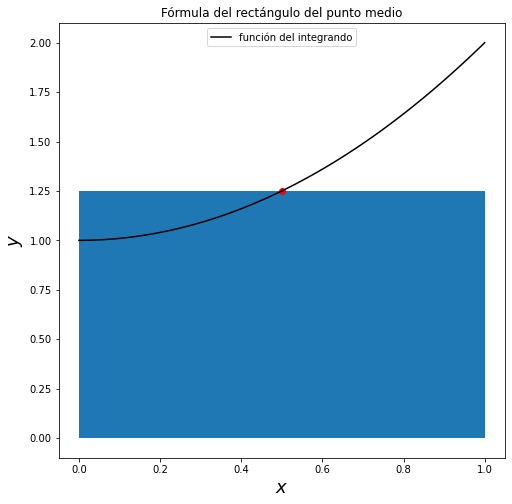

In [89]:
nxx = 100; a = 0; b = 1
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x0 = (a+b)/2; y0 = f(x0)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x0,y0,'ro',)
ax.plot(xx,yy,'k',label='función del integrando')
ax.add_patch(
    patches.Rectangle(
        (a, 0),   # (x,y) coordenadas esquina inferior izquierda
        b-a,      # anchura, y
        y0,       # altura del rectángulo
    )
)
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del rectángulo del punto medio');

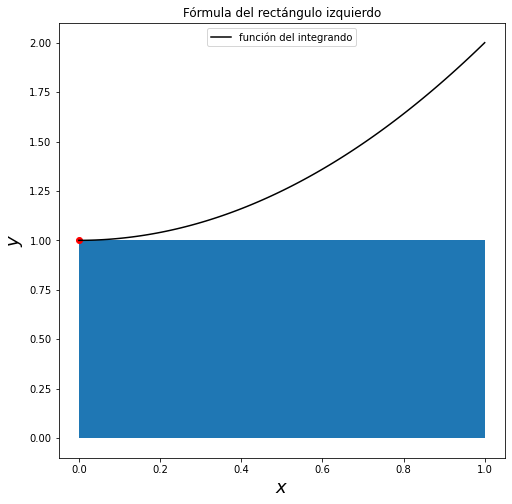

In [90]:
nxx = 100; a = 0; b = 1
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x0 = a; y0 = f(x0)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x0,y0,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
ax.add_patch(
    patches.Rectangle(
        (a, 0),   # (x,y) coordenadas esquina inferior izquierda
        b-a,      # anchura, y 
        y0,       # altura del rectángulo
    )
)
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del rectángulo izquierdo');

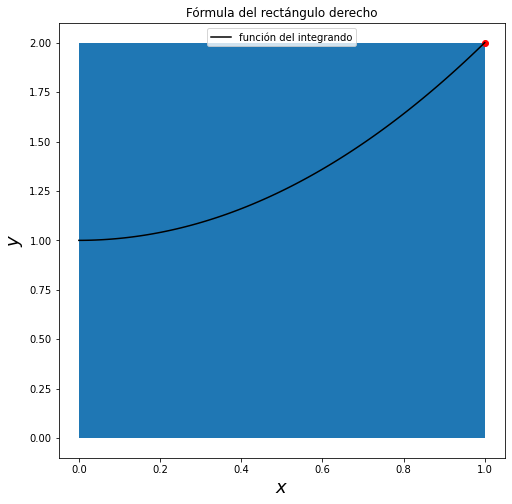

In [91]:
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x0 = b; y0 = f(x0)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x0,y0,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
ax.add_patch(
    patches.Rectangle(
        (a, 0),   # (x,y) coordenadas esquina inferior izquierda
        b-a,      # anchura, y
        y0,       # altura del rectángulo
    )
)
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del rectángulo derecho');

La idea ahora para obtener las correspondientes fórmulas compuestas, asociadas a estas reglas de cuadratura simples, sería aplicarlas a los subintervalos que obtendríamos al subdividir el intervalo original $[a,b]$ mediante una partición cualquiera del mismo:
$$a=x_0<x_1 < \ldots x_{i-1}<x_i<x_{i+1}<\ldots <x_{n-1}<x_n=b$$
aunque se suele emplear *particiones uniformes* (con $x_{i}-x_{i-1}=h\equiv \frac{b-a}{n},\; \forall i=1,\ldots,n$ para cierto valor entero natural $n\in \mathbb{N}$).

Así pues, para estas fórmulas de los rectángulos obtendríamos las siguientes expresiones en cada uno de los casos:

$$\int_a^b f(x)\,dx = \sum_{i=0}^{n-1}\int_{x_{i}}^{x_{i+1}} f(x)\,dx\simeq  \sum_{i=0}^{n-1} (x_{i+1}- x_{i}) f(\psi_i)$$

donde $\psi_i = x_{i}, x_{i+1}$ o bien $\frac{x_{i}+ x_{i+1}}{2}$ según se trate de la fórmula de los rectángulos a izquierda, derecha o del punto medio. 

Si se tratara de particiones uniformes podremos escribir

$$\int_a^b f(x)\,dx \simeq h \sum_{i=0}^{n-1} f(\psi_i)$$
con $\psi_i = a+ i h, a+(i+1) h$ o bien $a+ (i+1/2)h$ según el caso, y así podríamos programarlo también sin mucha dificultad.

### Fórmula compuesta de los rectángulos a izquierda

In [92]:
def formrectangizda(f,a,b,nx):
    """fórmula compuesta de los rectangulos a izquierda"""
    h = (b-a)/nx
    return h*sum([f(a+i*h) for i in range(0,nx)])

In [93]:
formrectangizda(f,a,b,100)

1.3283500000000001

In [94]:
formrectangizda(lambda z:z**2+1,0,1,100)

1.3283500000000001

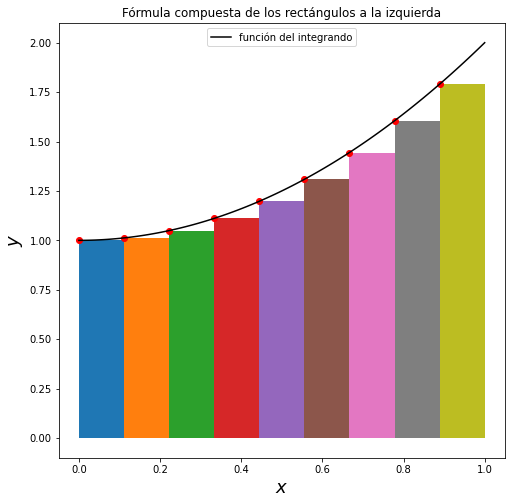

In [95]:
nxx = 100; nx=10
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x = np.linspace(a,b,nx); y = f(x)

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x[:-1],y[:-1],'ro')
ax.plot(xx,yy,'k',label='función del integrando')
for k in range(1,nx):
    zz = np.linspace(float(x[k-1]),float(x[k]),nxx)
    yk = [linea(z,x[k-1],y[k-1],x[k],y[k-1]) for z in zz]
    ax.fill_between(zz,0,yk);


ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula compuesta de los rectángulos a la izquierda');

### Fórmula compuesta de los rectángulos a derecha

In [96]:
def formrectangdcha(f,a,b,nx):
    """fórmula compuesta de los rectangulos a la derecha"""
    h = (b-a)/nx
    return h*sum([f(a+(i+1)*h) for i in range(0,nx)])

In [97]:
formrectangdcha(lambda z:z**2+1,0,1,100)

1.3383500000000002

In [98]:
formrectangdcha(f,0,1,100)

1.3383500000000002

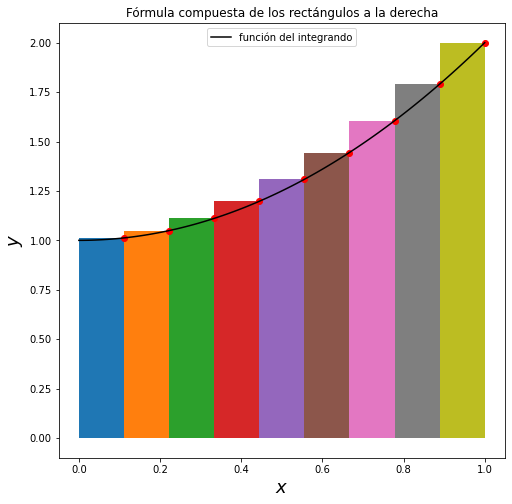

In [99]:
nx=10; x = np.linspace(a,b,nx); y = f(x)
nxx = 100;
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x[1:],y[1:],'ro')
ax.plot(xx,yy,'k',label='función del integrando')
for k in range(1,nx):
    zz = np.linspace(float(x[k-1]),float(x[k]),nxx)
    yk = [linea(z,x[k-1],y[k],x[k],y[k]) for z in zz]
    ax.fill_between(zz,0,yk);

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula compuesta de los rectángulos a la derecha');

### Fórmula compuesta de los rectángulos del punto medio

In [100]:
def formrectangptomedio(f,a,b,nx):
    """fórmula compuesta de los rectangulos de punto medio"""
    h = (b-a)/nx
    return h*sum([f(a+(i+1/2)*h) for i in range(0,nx)])

In [101]:
formrectangptomedio(lambda z:z**2+1,0,1,100)

1.333325

In [102]:
formrectangptomedio(f,0,1,100)

1.333325

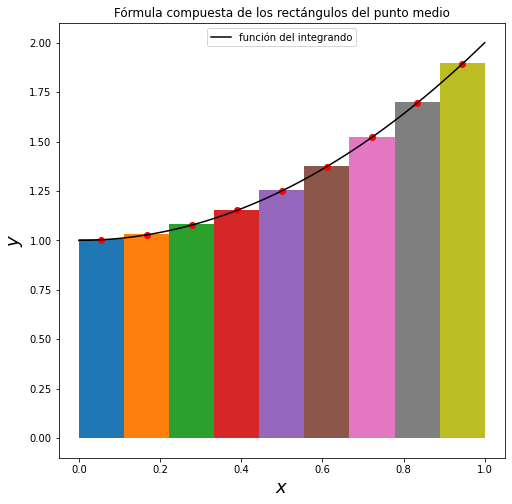

In [103]:
nxx = 100; nx=10
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x = np.linspace(a,b,nx); y = f(x)
x0 = (x[1:]+x[:-1])/2; y0 = f(x0)

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x0,y0,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
for k in range(1,nx):
    zz = np.linspace(float(x[k-1]),float(x[k]),nxx)
    yk = [linea(z,x[k-1],(y[k-1]+y[k])/2,x[k],(y[k-1]+y[k])/2) for z in zz]
    ax.fill_between(zz,0,yk);

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula compuesta de los rectángulos del punto medio');

## Fórmulas de los trapecios (simple y compuesta)

Si ahora empleamos trapecios, en vez de rectángulos, para aproximar las integrales de la función integrando en cada uno de los subintervalos $[x_{i},x_{i+1}],\; i=0,1,\ldots,n-1$, sabiendo por otra parte que el área de un trapecio de base $[x_{i},x_{i+1}]$ y alturas $f(x_{i})$ y $f(x_{i+1})$ es $(x_{i+1}-x_i)\frac{f(x_{i})+f(x_{i+1})}{2}$, entonces llegaríamos a las siguientes fórmulas de los trapecios:

- simple (con $n=1$ y $x_0=a, \; x_1=b$): 
$$\int_a^b f(x)\,dx\simeq (b-a)\frac{f(a)+f(b)}{2}$$
- compuesta (para cierto $n\in \mathbb{N}$, con $n>1$, y particiones arbitrarias): 
$$\int_a^b f(x)\,dx = \sum_{i=0}^{n-1}\int_{x_{i}}^{x_{i+1}} f(x)\,dx\simeq  \sum_{i=0}^{n-1} (x_{i+1}- x_{i})\, \frac{f(x_{i})+f(x_{i+1})}{2}$$
- compuesta (para cierto $n\in \mathbb{N}$, con $n>1$, y particiones uniformes): 
$$\int_a^b f(x)\,dx = \sum_{i=0}^{n-1}\int_{a+i\,h}^{a+(i+1)\,h} f(x)\,dx\simeq  h\; \sum_{i=0}^{n-1} \frac{f(a+i\,h)+f(a+(i+1)\,h)}{2} = \frac{h}{2}\left( f(a)+2\sum_{i=1}^{n-1}f(a+i\,h)+f(b)\right)$$

Nótese que por otro lado, la fórmula de los trapecios simple se obtiene sin más que integrar en el intervalo $[a,b]$ la función lineal que pasa por los puntos $(a,f(a))$ y $(b,f(b))$ de manera que  $$\int_a^b \left( \frac{f(b)-f(a)}{b-a}(x-a)+f(a) \right)\,dx 
= \left[ \frac{f(b)-f(a)}{b-a}\frac{(x-a)^2}{2}+f(a)(x-a) \right]_{x=a}^{x=b}=\frac{f(b)-f(a)}{b-a}\frac{(b-a)^2}{2}+f(a)(b-a)=\frac{b-a}{2}(f(b)-f(a)+2f(a))= \frac{b-a}{2}(f(a)+f(b))$$ 

In [104]:
def formtrapecios(f,a,b,nx):
    """fórmula compuesta de los trapecios"""
    h = (b-a)/nx
    return h/2*(f(a)+2*sum([f(a+i*h) for i in range(1,nx)])+f(b))

In [105]:
formtrapecios(lambda x:x**2+1 ,0,1,100)

1.33335

In [106]:
formtrapecios(f,0,1,100)

1.33335

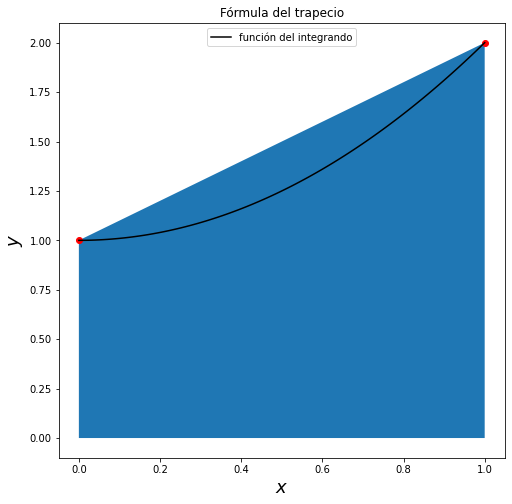

In [107]:
nxx = 100
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x0 = [a,b]; y0 = [f(a),f(b)]
zz = (y0[1]-y0[0])/(b-a)*(xx-a)+y0[0]
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x0,y0,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
ax.fill_between(xx,0,zz)
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del trapecio');

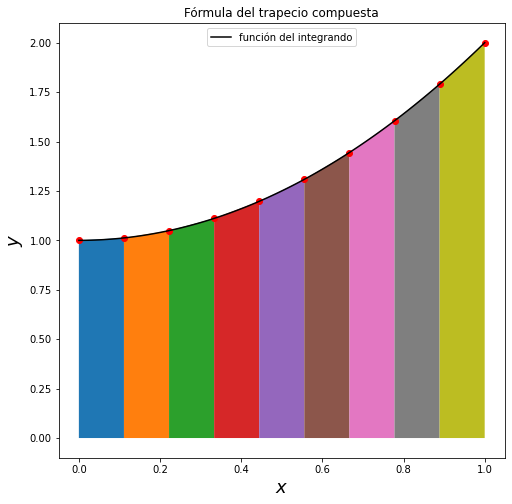

In [108]:
nxx = 100; nx=10
xx = np.linspace(float(a),float(b),nxx)
yy = f(xx)
x = np.linspace(a,b,nx); y = f(x)

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x,y,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
for k in range(1,nx):
    zz = np.linspace(float(x[k-1]),float(x[k]),nxx)
    yk = [linea(z,x[k-1],y[k-1],x[k],y[k]) for z in zz]
    ax.fill_between(zz,0,yk);

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del trapecio compuesta');

## Fórmulas de Simpson (simple y compuesta)

Ya hemos visto que las *fórmulas simples* de integración numérica  se pueden obtener sin más que sustituir la función del integrando por un polinomio de interpolación de grado cero (en el caso de las fórmulas de los rectángulos) o bien por un polinomio de grado uno que iterpola los valores de la función en ambos extremos del intervalo. 

Por otro lado, para obtener las correspondientes *fórmulas compuestas*, bastaría con sustituir la función en el intervalo total $[a,b]$ por funciones polinómicas a trozos: ya sea de grado cero discontínuas, (en el caso de las fórmulas de los rectángulos) o bien lineales continuas (en el caso de la fórmula de los trapecios compuesta).

En el caso de la fórmula de Simpson que nos ocupa ahora, este procedimiento se lleva un paso más allá, considerando ahora polinomios de grado $2$ (es decir, una parábola en el caso de la *fórmula de Simpson* simple o bien trozos de parábolas consecutivos, en el caso de la fórmula de Simpson compuesta).

Empecemos pues recordando la fórmula que nos proporciona la parábola que pasa por tres puntos del plano distintos, que ya fué deducida en la correspondiente práctica sobre la interpolación lagrangiana.

In [109]:
x = sp.Symbol('x')

In [110]:
def parabola(x,xL,yL,xM,yM,xR,yR):
    return yL -(x-xL)*(x-xM)*(xL*yM-xL*yR-xM*yL+xM*yR+xR*yL-xR*yM)/(xL**2*xM-xL**2*xR-xL*xM**2+xL*xR**2+xM**2*xR-xM*xR**2)+(x-xL)*(yL-yM)/(xL-xM)

In [111]:
# bastaría con una simple comprobación
parabola(x,xL,yL,xM,yM,xR,yR).subs({x:xL}),parabola(x,xL,yL,xM,yM,xR,yR).subs({x:xM}).simplify(),parabola(x,xL,yL,xM,yM,xR,yR).subs({x:xR}).simplify()

(yL, yM, yR)

Si ahora integramos la parábola que pasa por los puntos determinados por los valores de cierta función en los extremos del intervalo $[x_L,x_R]$: $(x_L,y_L)$ y $(x_R,y_R)$, así como por el correspondiente valor $y_M$ en el punto medio del intervalo $\frac{x_L+x_R}{2}$, obtendremos la fórmula de Simpson simple.

In [112]:
sp.integrate(parabola(x,xL,yL,(xL+xR)/2,yM,xR,yR),[x,xL,xR]).factor()

-(xL - xR)*(yL + 4*yM + yR)/6

In [113]:
print(_)

-(xL - xR)*(yL + 4*yM + yR)/6


In [114]:
def Simpsonsimple(xL,yL,yM,xR,yR):
    """Fórmula de Simpson simple"""
    return -(xL - xR)*(yL + 4*yM + yR)/6

In [115]:
f   = sp.Function('f') # ha hecho falta cambiar Symbol por Function
a,b = sp.symbols('a,b')

In [116]:
Simpsonsimple(a,f(a),f((a+b)/2),b,f(b))

(-a + b)*(f(a) + f(b) + 4*f(a/2 + b/2))/6

Un método alternativo, pero equivalente, consistiría en imponer exactitud al menos para los monomios generadores de la base canónica de  $\mathbb{P}_2\equiv gen(\{1,x,x^2\})$, los polinomios de grado menor o igual que $2$.  Veámos cómo sería el proceso para esta fórmula de Simpson.

In [117]:
list(range(3))

[0, 1, 2]

In [118]:
AB = sp.Matrix([ [a**k,((a+b)/2)**k,b**k, sp.integrate(x**k,[x,a,b])] for k in range(3)])
AB

Matrix([
[   1,              1,    1,           -a + b],
[   a,      a/2 + b/2,    b, -a**2/2 + b**2/2],
[a**2, (a/2 + b/2)**2, b**2, -a**3/3 + b**3/3]])

In [119]:
?sp.linsolve

Signature: sp.linsolve(system, *symbols)
Docstring:
Solve system of $N$ linear equations with $M$ variables; both
underdetermined and overdetermined systems are supported.
The possible number of solutions is zero, one or infinite.
Zero solutions throws a ValueError, whereas infinite
solutions are represented parametrically in terms of the given
symbols. For unique solution a :class:`~.FiniteSet` of ordered tuples
is returned.

All standard input formats are supported:
For the given set of equations, the respective input types
are given below:

.. math:: 3x + 2y -   z = 1
.. math:: 2x - 2y + 4z = -2
.. math:: 2x -   y + 2z = 0

* Augmented matrix form, ``system`` given below:

$$ \text{system} = \left[{array}{cccc}
    3 &  2 & -1 &  1\\
    2 & -2 &  4 & -2\\
    2 & -1 &  2 &  0
    \end{array}\right] $$

::

    system = Matrix([[3, 2, -1, 1], [2, -2, 4, -2], [2, -1, 2, 0]])

* List of equations form

::

    system  =  [3x + 2y - z - 1, 2x - 2y + 4z + 2, 2x - y + 2z]

* Input $A$ an

In [120]:
c0,c1,c2 = sp.symbols('c0,c1,c2')
sp.linsolve(AB,[c0,c1,c2])

{(-a/6 + b/6, -2*a/3 + 2*b/3, -a/6 + b/6)}

Vemos que hubiéramos obtenido exactamente la misma fórmula por este procedimiento

$$ \int_a^b f(x)\,dx \simeq \frac{b-a}{6} \left( f(a)+ 4f(\frac{a+b}{2}) +f(b) \right)$$

Ahora para obtener la correspondiente fórmula compuesta la idea sigue siendo la de aplicar esta misma fórmula, pero aplicada a cada par de subintervalos consecutivos: $[x_{i-1},x_i],\; [x_{i},x_{i+1}]$, con $x_i=\frac{x_{i-1}+x_{i+1}}{2}$.

Esta cuestión la tendremos asegurada por ejemplo si la partición de partida
$$a=x_0<x_1<\ldots<x_n=b$$ 
es uniforme y tiene un número par de subintervalos ($n=2m$, con $m\in \mathbb{N}$). Así pues

$$\int_a^b f(x)\,dx = \sum_{i=1}^{m}\int_{x_{2(i-1)}}^{x_{2i}} f(x)\,dx\simeq  \sum_{i=1}^{m} \frac{x_{2i}- x_{2(i-1)}}{6}\,
\left(f(x_{2(i-1)})+ 4 f(x_{2i-1}) + f(x_{2i}) \right) \\
= \frac{h}{3}\,\left(f(a)+2\sum_{i=1}^{m-1}f(x_{2i})
+4\sum_{i=1}^{m}f(x_{2i-1}) + f(b) \right)
$$
para $h:=\frac{b-a}{n}$, con $n=2m$ en el caso de una partición uniforme, con un número par de subintervalos de la misma longitud $h$.

In [121]:
def Simpsoncompuesta(f,a,b,m):
    """fórmula de Simpson compuesta"""
    h= (b-a)/(2*m)
    P = sum([f(a+2*i*h) for i in range(1,m)])
    I = sum([f(a+(2*i-1)*h) for i in range(1,m+1)])
    E = f(a)+f(b)
    return h/3*(E+2*P+4*I)

In [122]:
Simpsoncompuesta(lambda x:x**2,0,1,10),sp.integrate(x**2,[x,0,1])

(0.3333333333333333, 1/3)

Observamos la gran precisión de la fórmula de Simpson compuesta, que además es muy fácil de implementar en la práctica.

**Ejercicio:** Realice una comparativa entre los errores cometidos al aproximar una integral definida concreta (como por ejemplo, potencias sucesivas $x^i$, con $i=1,2,3,\ldots$) mediante las fórmulas de los trapecios y de Simpson compuestas; e inducir de ahí, los posibles órdenes de exactitud (a partir de los valores de $i$ que proporcionen valores exactos de la integral) y de aproximación (en función de $h=\frac{b-a}{n}$, con $n=2m$ para $m\in\mathbb{N}$) de ambas fórmulas. No deje de tener en cuenta los posibles errores de redondeo, inevitables en todo cálculo realizado con ordenador.

In [123]:
m = 50; a = 0; b = 1;
h = (b-a)/(2*m); h

0.01

In [124]:
k = 1; 
formtrapecios(lambda x:x**k ,a,b,2*m),Simpsoncompuesta(lambda x:x**k,a,b,m),(b**(k+1)-a**(k+1))/(k+1)

(0.5, 0.5, 0.5)

In [125]:
k = 2; 
formtrapecios(lambda x:x**k ,a,b,2*m),Simpsoncompuesta(lambda x:x**k,a,b,m),(b**(k+1)-a**(k+1))/(k+1)

(0.33335000000000004, 0.33333333333333337, 0.3333333333333333)

In [126]:
k = 3; 
formtrapecios(lambda x:x**k ,a,b,2*m),Simpsoncompuesta(lambda x:x**k,a,b,m),(b**(k+1)-a**(k+1))/(k+1)

(0.250025, 0.25, 0.25)

In [127]:
k = 4; 
formtrapecios(lambda x:x**k ,a,b,2*m),Simpsoncompuesta(lambda x:x**k,a,b,m),(b**(k+1)-a**(k+1))/(k+1)

(0.20003333300000006, 0.20000000133333337, 0.2)

In [128]:
f = func

In [129]:
m=5; # Veámos ahora gráficamente cómo se puede visualizar esta 
nx=2*m; nxx = 100;  # fórmula de Simpson compuesta
xx = np.linspace(float(a),float(b),nxx+1)
yy = f(xx)
x = np.linspace(a,b,nx+1); y = f(x)

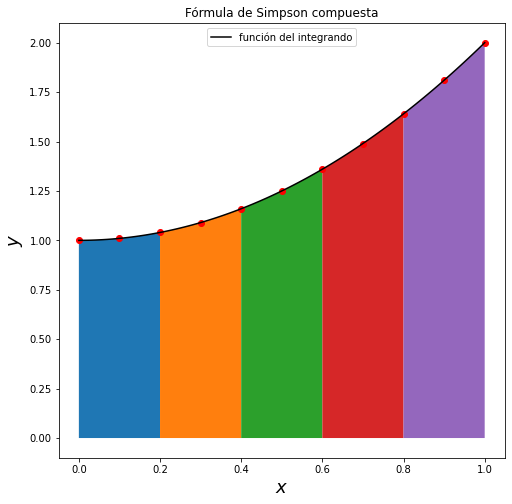

In [130]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x,y,'ro')
ax.plot(xx,yy,'k',label='función del integrando')

for k in range(1,m+1):
    zz = np.linspace(float(x[2*(k-1)]),float(x[2*k]),nxx)
    yk = [parabola(z,x[2*(k-1)],y[2*(k-1)],x[2*k-1],y[2*k-1],x[2*k],y[2*k]) for z in zz]
    ax.fill_between(zz,0,yk);

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula de Simpson compuesta');

## Fórmulas del Trapecio corregida

Por último, vamos a obtener la fórmula del trapecio corregida, es decir, la que usa como datos el valor de la función y el de la derivada en cada extremo.

In [131]:
x, d  = sp.symbols('x, d')

In [132]:
def parabolaconderivada(x,d,xL,yL,xR,yR):
    """parábola con derivada fijada en el primer punto"""
    return (yL*(xL-xR)**2+(x-xL)*(x-xR)*(d*(xL-xR)+(yR-yL))+(x-xL)*(xL-xR)*(yL-yR))/(xL-xR)**2

def cubicaconderivadas(x,xL,yL,dL,xR,yR,dR):
    """cúbica con datos de Lagrange y Hermite en ambos extremos"""
    # DR = sp.Symbol('DR')
    # DR = sp.Rational(dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR),(xL-xR)**3)
    DR = (dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR))/(xL-xR)**3
    return parabolaconderivada(x,dL,xL,yL,xR,yR) + DR*(x-xL)**2*(x-xR)

In [133]:
# hágamos las comprobaciones oportunas de su valor en los extremos
parabolaconderivada(x,d,xL,yL,xR,yR).subs({x:xL}), parabolaconderivada(x,d,xL,yL,xR,yR).subs({x:xR}).simplify()

(yL, yR)

In [134]:
# así como el valor de su derivada en el extremo izquierdo
sp.diff(parabolaconderivada(x,d,xL,yL,xR,yR),x).subs({x:xL}).simplify()

d

De manera totalmente equivalente se podría comprobar que la funcion `cubicaconderivadas` verifica las condiciones de interpolación correspondientes en ambos extremos del intervalo $[x_L,x_R]$, $p(x_k)=y_k, p'(x_k)=d_k$, con $k=L,R$.

In [135]:
f   = sp.Function('f')
df  = sp.Function('df')
a,b, d = sp.symbols('a,b, d')

In [136]:
cubicaconderivadas(x,a,f(a),df(a),b,f(b),df(b))

(-a + x)**2*(-b + x)*(a*df(a) + a*df(b) - b*df(a) - b*df(b) - 2*f(a) + 2*f(b))/(a - b)**3 + ((-a + x)*(a - b)*(f(a) - f(b)) + (-a + x)*(-b + x)*((a - b)*df(a) - f(a) + f(b)) + (a - b)**2*f(a))/(a - b)**2

In [137]:
sp.integrate(cubicaconderivadas(x,a,f(a),df(a),b,f(b),df(b)),[x,a,b]).factor()

(a - b)*(a*df(a) - a*df(b) - b*df(a) + b*df(b) - 6*f(a) - 6*f(b))/12

In [138]:
print(_)

(a - b)*(a*df(a) - a*df(b) - b*df(a) + b*df(b) - 6*f(a) - 6*f(b))/12


Obtenemos pues finalmente la siguiente *fórmula del trapecio corregida*

$$\int_a^b f(x)\,dx \simeq \frac{b-a}{12}\left(6(f(a)+f(b))
-(b-a)(f'(b)-f'(a)) \right)
$$

In [139]:
(b-a)*(-a*df(a)+a*df(b)+b*df(a)-b*df(b)+6*f(a)+6*f(b))/12

(-a + b)*(-a*df(a) + a*df(b) + b*df(a) - b*df(b) + 6*f(a) + 6*f(b))/12

In [140]:
a = 0; b = 1; f = func; df = dfunc

In [141]:
nx=10;
x = np.linspace(a,b,nx); y = f(x)
d = df(x)

In [142]:
nxx = 100;
xx = np.linspace(a,b,nxx)
yy = f(xx)

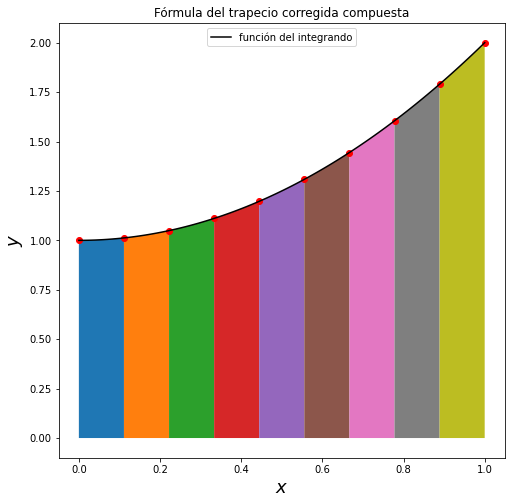

In [143]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x,y,'ro')
ax.plot(xx,yy,'k',label='función del integrando')
for k in range(1,nx):
    zz = np.linspace(float(x[k-1]),float(x[k]),nxx)
    yk = [cubicaconderivadas(z,x[k-1],y[k-1],d[k-1],x[k],y[k],d[k]) for z in zz]
    ax.fill_between(zz,0,yk);

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Fórmula del trapecio corregida compuesta');

**Ejercicio:** Escribir y a continuación implementar la correspondiente fórmula compuesta asociada a esta nueva fórmula del trapecio corregida cuando se aplique a una función derivable en un intervalo genérico $[a,b]$.

In [144]:
def formtrapecioscorregida(f,df,a,b,nx):
    h = (b-a)/nx
    return h/2*(f(a)+f(b)+2*sum([f(a+i*h) for i in range(1,nx)]))-h**2/12*(df(b)-df(a))

In [145]:
k=2;
formtrapecioscorregida(lambda z:z**k,lambda z:k*z**(k-1),0,1,1000)

0.33333333333333326

In [146]:
k=2; ncifras = 10; # juegue con los valores de k y ncifras
sp.N(1/(k+1),ncifras),sp.N(formtrapecioscorregida(lambda z:z**k,lambda z:k*z**(k-1),0,1,1000),ncifras)

(0.3333333333, 0.3333333333)

## Fórmulas gaussianas

Las fórmulas gaussianas usan como nodos aquellos que conducen a una precisión máxima. Si vamos a construir una fórmula de integración numérica con $n$ nodos, sabemos que podemos elegirlos de manera única, de forma que la fórmula correspondiente alcanza precisión $2n-1$. Por tanto, para construir fórmulas gaussianas, hemos de calcular los nodos y los coeficientes. Tenemos varias alternativas; una de ellas es plantear el sistema no lineal de las $2n$ incógnitas que resulta de imponer exactitud para $1, x, \ldots,x^{2n-1}$. 

Lo haremos a continuación, puesto que *Python* (o cualquier otro sistema que permita realizar cálculos simbólicos, o bien numéricos) lo resuelve sin dificultad para valores de $n$ bajos. También sabemos que los nodos de una fórmula gaussiana son los ceros de cierto polinomio ortogonal. Para los productos escalares más usuales, los *polinomios ortogonales* correspondientes están contenidos en ciertos módulos concretos de *Python*; por tanto, podemos calcular sus raíces para obtener dichos nodos. Lo haremos para el polinomio de Laguerre. En un caso especial es posible encontrar el polinomio ortogonal correspondiente y calcular sus raíces con la orden correspondiente.

### La fórmula gaussiana con dos nodos y peso $w=1$

In [147]:
?f

Signature: f(z)
Docstring: función z^2+1
File:      /tmp/ipykernel_26266/452894248.py
Type:      function


In [148]:
f = sp.Function('f')

In [149]:
a = -1; b = 1; n = 2
grexact = 2*n-1

In [150]:
n,grexact

(2, 3)

In [151]:
p = sp.symbols('p1:'+ str(n+1)) # generamos una tupla de n nodos
nodos1 = list(p)
nodos1

[p1, p2]

In [152]:
c = sp.symbols('c1:'+ str(n+1)) # generamos una tupla de n coeficientes
coefs1 = list(c)
coefs1

[c1, c2]

In [153]:
 # Esto también funcionaba así en versiones anteriores de Sympy
# p,c = sp.symbols('p,c') 
# nodos1 = [p(i) for i in range(n)]
# coefs1 = [c(i) for i in range(n)]
incogs1 = coefs1 + nodos1   # aquí el signo '+' indica simplemente 
# yuxtaposición de las listas de nodos y coeficientes

In [154]:
incogs1  # Esta sería pues la lista completa de incógnitas

[c1, c2, p1, p2]

In [155]:
[[(z**i).subs({z:nodos1[j]}) for j in range(n)] for i in range(grexact)]

[[1, 1], [p1, p2], [p1**2, p2**2]]

In [156]:
ecs1 = [np.dot([(z**i).subs({z:nodos1[j]}) for j in range(n)],coefs1)-sp.Rational(b**(i+1)-a**(i+1),(i+1)) for i in range(grexact+1)]
ecs1  # Y así construimos pues el conjunto de ecuaciones a resolver

[c1 + c2 - 2, c1*p1 + c2*p2, c1*p1**2 + c2*p2**2 - 2/3, c1*p1**3 + c2*p2**3]

In [157]:
solsGauss1 = sp.solve(ecs1,incogs1)
solsGauss1

[(1, 1, -sqrt(3)/3, sqrt(3)/3), (1, 1, sqrt(3)/3, -sqrt(3)/3)]

In [158]:
for i in range(n):  # Y así le asignaríamos a los coeficientes 
    coefs1[i] = solsGauss1[0][i]  # las soluciones obtenidas
coefs1

[1, 1]

In [159]:
for i in range(n):   # Y así le asignaríamos a los nodos
    nodos1[i] = solsGauss1[0][n+i] # las soluciones obtenidas
nodos1

[-sqrt(3)/3, sqrt(3)/3]

In [160]:
formGauss1 = np.dot([f(nodos1[i]) for i in range(n)],coefs1) # Aquí realizamos un simple producto escalar 
formGauss1           # multiplicando término a término los valores de los coeficientes por la evaluación de la función evaluada
# en los nodos obtenidos y sumando posteriormente esos términos obtenidos.

f(-sqrt(3)/3) + f(sqrt(3)/3)

Vemos pues que con la ayuda del comando `solve` del módulo de cálculo simbólico `SymPy` hemos podido obtener sin demasiado problema tanto los coeficientes de la fórmula Gaussiana como los nodos que hace falta considerar para obtener la máxima exactitud en el intervalo considerado ($[-1,1]$ en este caso). También vemos que
uno de los posibles inconvenientes para la obtención de estas fórmulas gaussianas es que debemos resolver sistemas de ecuaciones no lineales, no siempre fáciles de resolver, aparte de que los nodos suelen ser números trascencentes, y si no trabajáramos en simbólico, ya su mera aproximación introduciría un primer error.

### Una fórmula gaussiana para una integral impropia con función peso no idénticamente uno

In [161]:
a = 0; b = sp.oo;  # En este caso estaremos obteniendo una fórmula de integración numérica para la semirecta
(a,b)              # formada por todos los números reales positivos  

(0, oo)

In [162]:
x = sp.Symbol('x')
def w(x):
    """función peso"""
    return sp.exp(-x)

In [163]:
w(-1),w(0),w(1)

(E, 1, exp(-1))

In [164]:
n = 2; grexact = 2*n-1

In [165]:
p = sp.symbols('p0:'+ str(n)) # generamos una tupla de n nodos
nodos2 = list(p)
nodos2

[p0, p1]

In [166]:
c = sp.symbols('c0:'+ str(n)) # generamos una tupla de n coeficientes
coefs2 = list(c)
coefs2

[c0, c1]

In [167]:
# p,c = sp.symbols('p,c') 
# nodos2 = [p(i) for i in range(n)]
# coefs2 = [c(i) for i in range(n)]
incogs2 = coefs2 + nodos2
incogs2

[c0, c1, p0, p1]

In [168]:
ecs2 = [np.dot([(z**i).subs({z:nodos2[j]}) for j in range(n)],coefs2)-sp.integrate(w(x)*x**i,(x,a,b)) for i in range(grexact+1)]
ecs2

[c0 + c1 - 1,
 c0*p0 + c1*p1 - 1,
 c0*p0**2 + c1*p1**2 - 2,
 c0*p0**3 + c1*p1**3 - 6]

In [169]:
solsGauss2 = sp.solve(ecs2,incogs2)
solsGauss2

[(1/2 - sqrt(2)/4, sqrt(2)/4 + 1/2, sqrt(2) + 2, 2 - sqrt(2)),
 (sqrt(2)/4 + 1/2, 1/2 - sqrt(2)/4, 2 - sqrt(2), sqrt(2) + 2)]

In [170]:
for i in range(n):
    coefs2[i] = solsGauss2[0][i]
coefs2

[1/2 - sqrt(2)/4, sqrt(2)/4 + 1/2]

In [171]:
for i in range(n):
    nodos2[i] = solsGauss2[0][n+i]
nodos2

[sqrt(2) + 2, 2 - sqrt(2)]

In [172]:
for i in range(n):
    coefs2[i] = solsGauss2[0][i]
coefs2

[1/2 - sqrt(2)/4, sqrt(2)/4 + 1/2]

In [173]:
formGauss2 = np.dot([f(nodos2[i]) for i in range(n)],coefs2)
formGauss2

(sqrt(2)/4 + 1/2)*f(2 - sqrt(2)) + (1/2 - sqrt(2)/4)*f(sqrt(2) + 2)

Por otro lado, también podemos llegar a esta misma fórmula partiendo de los ceros del polinomio de Laguerre.

In [174]:
from scipy.special import laguerre

In [175]:
?laguerre

Signature: laguerre(n, monic=False)
Docstring:
Laguerre polynomial.

Defined to be the solution of

.. math::
    x\frac{d^2}{dx^2}L_n + (1 - x)\frac{d}{dx}L_n + nL_n = 0;

:math:`L_n` is a polynomial of degree :math:`n`.

Parameters
----------
n : int
    Degree of the polynomial.
monic : bool, optional
    If `True`, scale the leading coefficient to be 1. Default is
    `False`.

Returns
-------
L : orthopoly1d
    Laguerre Polynomial.

Notes
-----
The polynomials :math:`L_n` are orthogonal over :math:`[0,
\infty)` with weight function :math:`e^{-x}`.

See Also
--------
genlaguerre : Generalized (associated) Laguerre polynomial.

References
----------
.. [AS] Milton Abramowitz and Irene A. Stegun, eds.
    Handbook of Mathematical Functions with Formulas,
    Graphs, and Mathematical Tables. New York: Dover, 1972.

Examples
--------
The Laguerre polynomials :math:`L_n` are the special case
:math:`\alpha = 0` of the generalized Laguerre polynomials
:math:`L_n^{(\alpha)}`.
Let's verify

In [176]:
laguerre(0),laguerre(1),laguerre(2)

(poly1d([1.]), poly1d([-1.,  1.]), poly1d([ 0.5, -2. ,  1. ]))

In [177]:
laguerre(2) # poly1d es un formato específico para almacenar este 
# tipo de polinomios ortogonales, pero no vamos a verlo en detalle

poly1d([ 0.5, -2. ,  1. ])

In [178]:
laguerre(2).weights # este atributo de la clase poly1d nos permite
# obtener los ceros del correspondiente polinomio, así como otros
# parámetros interesantes para confeccionar fórmulas gaussianas.

array([[0.58578644, 0.85355339, 1.53332603],
       [3.41421356, 0.14644661, 4.45095734]])

In [179]:
nodos = (laguerre(2).weights)[0,0],(laguerre(2).weights)[1,0]
nodos

(0.585786437626905, 3.4142135623730954)

In [180]:
nodos2

[sqrt(2) + 2, 2 - sqrt(2)]

In [181]:
2-np.sqrt(2),2+np.sqrt(2) # nótese que en este último caso aparecen pequeños errores de redondeo
                          # al trabajar con números en coma flotante

(0.5857864376269049, 3.414213562373095)

In [182]:
laguerre(2).weights

array([[0.58578644, 0.85355339, 1.53332603],
       [3.41421356, 0.14644661, 4.45095734]])

In [183]:
coefs = (laguerre(2).weights)[0,1],(laguerre(2).weights)[1,1]
coefs   # aquí también aparecen pequeños errores de redondeo

(0.8535533905932737, 0.14644660940672624)

In [184]:
sp.N(coefs2[1]),sp.N(coefs2[0]) 


(0.853553390593274, 0.146446609406726)

Vemos entonces que tenemos de esta forma todo lo que necesitamos para construir la fórmula gaussiana de integración numérica que obtuvimos previamente

In [185]:
?f

Init signature: f(*args)
Docstring:     
Base class for expressions resulting from the application of an undefined
function.
File:           ~/.local/lib/python3.10/site-packages/sympy/core/function.py
Type:           UndefinedFunction
Subclasses:     


In [186]:
f = sp.Function('f')

In [187]:
np.dot([f(nodos2[k]) for k in range(len(nodos2))],coefs2)

(sqrt(2)/4 + 1/2)*f(2 - sqrt(2)) + (1/2 - sqrt(2)/4)*f(sqrt(2) + 2)

In [188]:
def integGauss2(f):
    """integración Gaussiana en [0,oo[ usando pols. de Laguerre"""
    return np.dot([f(nodos[k]) for k in range(len(nodos))],coefs)

In [189]:
integGauss2(lambda x:x**2)

2.0000000000000004

## Otras posibilidades para la integración numérica usando algunos módulos de Python

*Python* tiene también  varias órdenes para la integración de funciones, ya sea de manera simbólica o numérica. Cada una de ellas vendrá implementada en cierto módulo concreto de Python, por lo que será conveniente saber dónde y cómo deberemos cargar y usar dichas órdenes.

Por ejemplo, para la integración simbólica usaremos evidentemente la orden correspondiente incorporada en el módulo `SymPy`. Esta órden es `integrate` (parecida a la orden `Integrate` de *Mathematica*) y a continuación vemos algunos ejemplos de uso, tanto para obtener integrales indefinidas (primitivas) como integrales definidas, de forma exacta siempre que sea posible. Nótese que esta orden requiere que la función tenga una primitiva, a la que aplica la regla de Barrow en el caso de tratarse de una integral definida.

In [190]:
x = sp.Symbol('x')

In [191]:
sp.integrate(x,x),sp.integrate(x,[x,0,1])

(x**2/2, 1/2)

In [192]:
sp.integrate(x**2,x),sp.integrate(x**2,[x,0,1])

(x**3/3, 1/3)

In [193]:
sp.integrate(x**3-x+2,x) # primitiva salvo constantes de un polinomio

x**4/4 - x**2/2 + 2*x

In [194]:
sp.integrate(x**3-x+2,[x,0,1]),sp.integrate(x**3-x+2,[x,0,1.])
# Nótese aquí el efecto de indicar alguno de los límites 
# de integración con el punto decimal

(7/4, 1.75000000000000)

In [195]:
sp.integrate(sp.exp(x**2),x)

sqrt(pi)*erfi(x)/2

In [196]:
sp.integrate(sp.exp(x**2),[x,0,1])

sqrt(pi)*erfi(1)/2

In [197]:
sp.integrate(sp.exp(-x**2),[x,-sp.oo,sp.oo])

sqrt(pi)

In [198]:
sp.integrate(sp.cos(x**2),x)

sqrt(2)*sqrt(pi)*fresnelc(sqrt(2)*x/sqrt(pi))*gamma(1/4)/(8*gamma(5/4))

In [199]:
sp.integrate(sp.cos(x**2),[x,0,1])

sqrt(2)*sqrt(pi)*fresnelc(sqrt(2)/sqrt(pi))*gamma(1/4)/(8*gamma(5/4))

**Ejercicio:** Intente integrar en el intervalo $[1,2]$ las funciones $e^x x$ y $\frac{e^x}{x}$, usando la orden `integrate` y por otro lado calculando previamente una primitiva de la función integrando y aplicando la conocida regla de Barrow. Compare los resultados.

In [200]:
def f(x):
    return sp.exp(x)/x
f(1),f(2)

(E, exp(2)/2)

In [201]:
sp.integrate(f(x),x)

Ei(x)

In [202]:
sp.N(sp.integrate(f(x),[x,1,2]))

3.05911653964595

Por otro lado estarían las órdenes específicas para la integración numérica, entre las que resaltamos la órden `quad` (igual que en MATLAB/Octave) para la integración de funciones de una variable. Existen las correspondientes versiones para funciones de dos y tres variables (`dblquad` y `tplquad`) que nos permmitirán aproximar numéricamente integrales dobles y triples, respectivamente. Todas ellas se encuentran implementadas dentro del submódulo `integrate` del módulo `SciPy` y tendremos que cargarlas previamente para poder usarlas.

In [203]:
from scipy.integrate import quad, dblquad, tplquad

Empecemos con la orden `quad`, que nos permitirá aproximar la integral definida de una función real de variable real en un intervalo determinado. Así pues, esta orden lleva programada una integración numérica adaptativa que puede en principio ser aplicada a cualquier función definida y acotada en un intervalo $[a,b]$.
Por otro lado, tiene bastantes argumentos opcionales que pueden ser usados para afinar mucho más en el cálculo de dicha aproximación numérica (pruebe a escribir `?quad` o `help(quad)` para más detalles).

In [204]:
?quad

Signature:
quad(
    func,
    a,
    b,
    args=(),
    full_output=0,
    epsabs=1.49e-08,
    epsrel=1.49e-08,
    limit=50,
    points=None,
    weight=None,
    wvar=None,
    wopts=None,
    maxp1=50,
    limlst=50,
)
Docstring:
Compute a definite integral.

Integrate func from `a` to `b` (possibly infinite interval) using a
technique from the Fortran library QUADPACK.

Parameters
----------
func : {function, scipy.LowLevelCallable}
    A Python function or method to integrate. If `func` takes many
    arguments, it is integrated along the axis corresponding to the
    first argument.

    If the user desires improved integration performance, then `f` may
    be a `scipy.LowLevelCallable` with one of the signatures::

        double func(double x)
        double func(double x, void *user_data)
        double func(int n, double *xx)
        double func(int n, double *xx, void *user_data)

    The ``user_data`` is the data contained in the `scipy.LowLevelCallable`.
    In the call

In [205]:
def f(x):
    """función del integrando: x^2+1"""
    return x**2+1

In [206]:
# No obstante, su uso básico sería el siguiente:
# f sería la función del integrando, 
# que debería estar definida previamente
# a no ser que usemos una función anónima, del tipo `lambda`
    
x_min = 0 # el límite inferior en la variable de integración x
x_max = 1 # el límite superior en la variable de integración x

val, abserr = quad(f, x_min, x_max)

# en las variables val y abserr almacenaremos el valor aproximado
# de la integral, así como la estimación del error cometido en
# valor absoluto

print ("valor aprox. de la integral =", val, ",\n", "error estimado =", abserr) 

valor aprox. de la integral = 1.3333333333333333 ,
 error estimado = 1.4802973661668752e-14


# Ejercicios

1.- Obtenga mediante interpolación en el espacio $\mathbb{P}_2$ una fórmula para aproximar $f''(a)$ del tipo combinación
de $f(a-h)$, $f(a)$ y $f(a+h)$.

2.- Con la fórmula obtenida en el ejercicio 1, halle una tabla de aproximaciones y errores de $f_1''(2.5)$, siendo $f_1(x)=x^x$, para $h=10^{-i},\; i=1,\ldots,5.$

3.- Sea $f_2(x)=\frac{x^2+40}{x+\sqrt{5x}+7}$. Calcule una tabla que recoja las derivadas de $f_2$ en $x_i=1,2,\ldots,10$, utilizando alguna de las fórmulas de derivación numérica de primer orden obtenidas al inicio de la práctica, con $h=10^{-3}$, y muestre al mismo tiempo el error cometido en cada punto. Repita el ejercicio con la fórmula centrada obtenida para la derivada primera y, finalmente, para la obtenida en el ejercicio 1 (con respecto a la segunda derivada).

4.- Divida el intervalo $[1,2]$ en 100 partes iguales y aplique las fórmulas del rectángulo, Simpson y trapecio compuestas para aproximar la integral en dicho intervalo de $f_1$. Compare dichos resultados.

5.- Repita el ejercicio 4 para $f_2$. 

6.- Sea $f_3(x)=x^{15} e^x$ en $[0,2]$. Vamos a dividir el intervalo en $10\times 2^n$ subintervalos, es decir, $10,\,20,\,40,\, 80,\ldots $ y a aplicar la fórmula de Simpson compuesta hasta que la diferencia entre dos aproximaciones consecutivas (por ejemplo, podrían
ser con $20$ y $40$ subintervalos) sea menor que $10^{-2}$, dando en tal caso por buena la última aproximación obtenida. Programe
y calcule dicha aproximación. Compare ambas aproximaciones con
el valor exacto.

7.- Calcule las fórmulas gaussianas con $2$ y $3$ nodos,en el intervalo $[-1,1]$, siendo la función peso el valor absoluto de la variable. Aplíquelas para aproximar la función $x\; e^x$ en $[-1,1]$ y compare los resultados con el valor exacto (organizando los cálculos de forma adecuada).

8.- Programar las técnicas de integración de Romberg y adaptativa, para después aplicarlas a la aproximación de la siguiente integral $$\int_a^b p(x)\, dx$$
siendo  $\;a=\displaystyle\min_{0\leq i\leq 7}{d_i}$, $\;b=\displaystyle\max_{0\leq i\leq 7}{d_i}$ y 
$$p(x)=d_0 + d_1 x + d_2 x^2 + d_3 x^3+ d_4 x^4 + d_5 x^5 + d_6 x^6 + d_7 x^7 $$
(siendo $d_0, d_1, \ldots, d_7$ los dígitos de su DNI, pasaporte o tarjeta de residente).